## Проект: вариант 3. Проведение A/B-теста в дейтинговом приложении.

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm

from datetime import date
from tqdm.auto import tqdm

In [3]:
# Выгружаем данные
users_test      = pd.read_csv('/Users/Александр/Desktop/Python/Karpov/Финальный проект/Проект_3_users_test.csv', sep=';')
users_control_1 = pd.read_csv('/Users/Александр/Desktop/Python/Karpov/Финальный проект/Проект_3_users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('/Users/Александр/Desktop/Python/Karpov/Финальный проект/Проект_3_users_control_2.csv', sep=';')

transactions_test      = pd.read_csv('/Users/Александр/Desktop/Python/Karpov/Финальный проект/Проект_3_transactions_test.csv', sep=';')
transactions_control_1 = pd.read_csv('/Users/Александр/Desktop/Python/Karpov/Финальный проект/Проект_3_transactions_control_1.csv', sep=';')
transactions_control_2 = pd.read_csv('/Users/Александр/Desktop/Python/Karpov/Финальный проект/Проект_3_transactions_control_2.csv', sep=';')

In [4]:
# Добавляем в данные столбец 'group_type', чтобы при объединении таблиц мы знали где тестовая, а где контрольные группы.
users_test      = users_test.assign(group_type = 'test')
users_control_1 = users_control_1.assign(group_type = 'control_1')
users_control_2 = users_control_2.assign(group_type = 'control_2')

transactions_test      = transactions_test.assign(group_type = 'test')
transactions_control_1 = transactions_control_1.assign(group_type = 'control_1')
transactions_control_2 = transactions_control_2.assign(group_type = 'control_2')

In [5]:
users        = pd.concat([users_test, users_control_1, users_control_2])
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

In [6]:
# Проверяем на наличие дубликатов и NaN.
users.duplicated().sum()

0

In [7]:
users.isna().sum()

uid                     0
age                     0
attraction_coeff        0
coins               12742
country                 0
visit_days           4018
gender                  0
age_filter_start        0
age_filter_end          0
views_count             0
was_premium         11657
is_premium          12372
total_revenue           0
group_type              0
dtype: int64

In [8]:
# Мы можем заменить NaN на 0.
# Coins - отсутствие монет.
# Visit_days - в эти дни не было посещений.
# Was_premium - премиума не было.
# Is-premium - не является премиумом.
users = users.fillna(0)

In [9]:
transactions.duplicated().sum()

662

In [10]:
transactions.isna().sum()

uid             630
country         630
joined_at         0
paid_at           0
revenue         630
payment_id      630
from_page       630
product_type    630
group_type        0
dtype: int64

In [11]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1608 entries, 0 to 327
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           978 non-null    float64
 1   country       978 non-null    object 
 2   joined_at     1608 non-null   object 
 3   paid_at       1608 non-null   object 
 4   revenue       978 non-null    float64
 5   payment_id    978 non-null    float64
 6   from_page     978 non-null    object 
 7   product_type  978 non-null    object 
 8   group_type    1608 non-null   object 
dtypes: float64(3), object(6)
memory usage: 125.6+ KB


In [12]:
# Оставляем только те данные, по которым были транзакции, а также удаляем дубликаты.
transactions.drop_duplicates(inplace=True)
transactions.dropna(inplace=True)

In [13]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 945 entries, 0 to 327
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           945 non-null    float64
 1   country       945 non-null    object 
 2   joined_at     945 non-null    object 
 3   paid_at       945 non-null    object 
 4   revenue       945 non-null    float64
 5   payment_id    945 non-null    float64
 6   from_page     945 non-null    object 
 7   product_type  945 non-null    object 
 8   group_type    945 non-null    object 
dtypes: float64(3), object(6)
memory usage: 73.8+ KB


In [14]:
# Преобразуем данные.
transactions.uid       = transactions.uid.astype('int64')
transactions.joined_at = pd.to_datetime(transactions.joined_at)
transactions.paid_at   = pd.to_datetime(transactions.paid_at)

### Проверим данные на выбросы.

<AxesSubplot:xlabel='total_revenue', ylabel='group_type'>

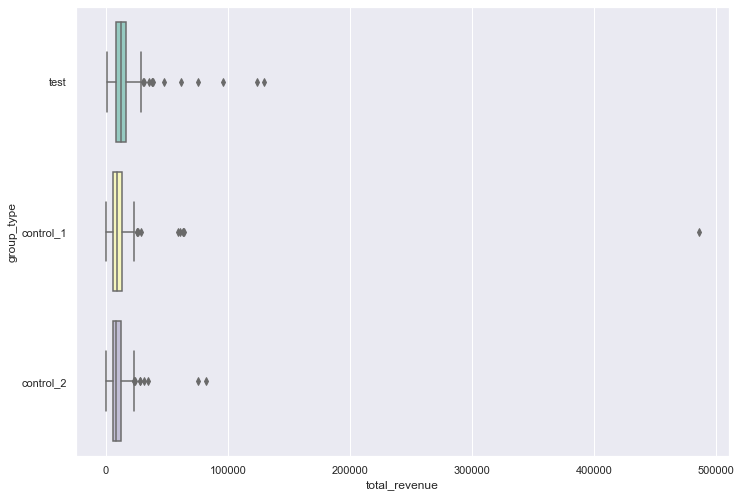

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="total_revenue", y="group_type", data=users.query('total_revenue > 0'), orient="h", palette="Set3")

Предположительно, такой сильный выброс - ошибочный.

In [16]:
users.query('group_type == "control_1"').total_revenue.max()
users.query('total_revenue == 486330')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group_type
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,control_1


In [17]:
users = users.drop(labels = [1427],axis = 0)

<AxesSubplot:xlabel='total_revenue', ylabel='group_type'>

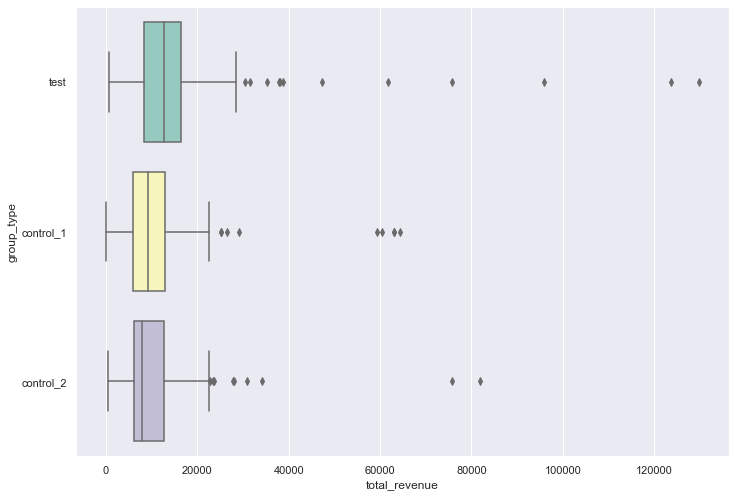

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="total_revenue", y="group_type", data=users.query('total_revenue > 0'), orient="h", palette="Set3")

In [19]:
transactions.query('uid == 892333905')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group_type
6,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins,control_1
13,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,control_1
28,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,control_1
43,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,control_1
49,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,control_1
63,892333905,Italy,2017-10-16 01:38:00,2017-10-16 22:35:00,31525.0,19.0,menu,coins,control_1
76,892333905,Italy,2017-10-16 01:38:00,2017-10-16 18:42:00,31525.0,19.0,fans,coins,control_1
126,892333905,Italy,2017-10-16 01:38:00,2017-10-16 22:39:00,19773.0,146.0,menu,coins,control_1
137,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,31525.0,19.0,gifts,coins,control_1
143,892333905,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147.0,no_sympathy,premium_no_trial,control_1


In [20]:
transactions = transactions.drop(labels = [6,13,28,43,49,63,76,126,137,143,149,166,256,289,297,306,316,335,358],axis = 0)

<AxesSubplot:xlabel='revenue', ylabel='group_type'>

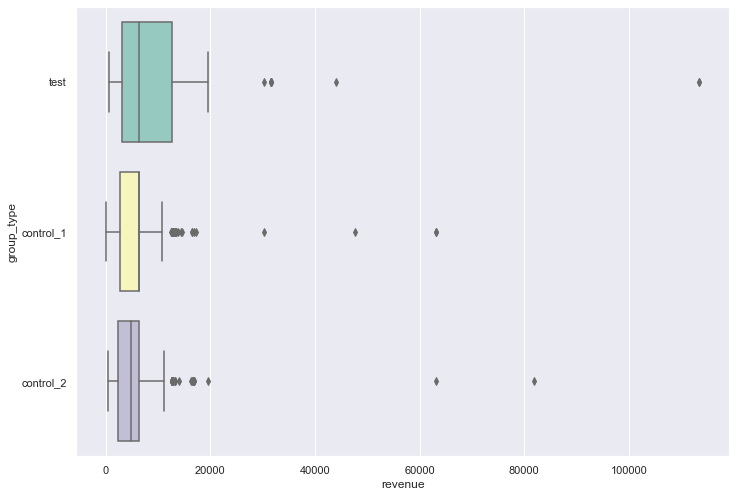

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="revenue", y="group_type", data=transactions.query('revenue > 0'), orient="h", palette="Set3")

#### После того, как подготовили данные, определим метрики для аналитики приложения.
Мы изменили стоимость премиум подписки, следовательно мы хотим увидеть:
- как изменились показатели прибыли,
- как изменились показатели конверсии в платную премиум-подписку.

Далее проанализируем, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

In [22]:
users.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group_type
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test


In [23]:
transactions.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test


In [24]:
# Рассчитаем ARPU для тестовой группы
print(users.query('group_type == "test"').total_revenue.sum() / users.query('group_type == "test"').uid.nunique())

# Рассчитаем ARPU для первой контрольной группы
print(users.query('group_type == "control_1"').total_revenue.sum() / users.query('group_type == "control_1"').uid.nunique())

# Рассчитаем ARPU для второй контрольной группы
print(users.query('group_type == "control_2"').total_revenue.sum() / users.query('group_type == "control_2"').uid.nunique())

534.2043185511957
482.81562572021204
450.48979591836735


Согласно полученным результатам, ARPU в тестовой группе выше, чем в контрольных группах.

###### Для сравнения рассчитаем ARPPU для тестовой и контрольных групп.

In [25]:
# ARPPU для тестовой группы
print(users.query('group_type == "test" and total_revenue > 0').total_revenue.sum() / users.query('group_type == "test" and total_revenue > 0').uid.nunique())

# ARPPU для первой контрольной группы
print(users.query('group_type == "control_1" and total_revenue > 0').total_revenue.sum() / users.query('group_type == "control_1" and total_revenue > 0').uid.nunique())

# ARPPU для второй контрольной группы
print(users.query('group_type == "control_2" and total_revenue > 0').total_revenue.sum() / users.query('group_type == "control_2" and total_revenue > 0').uid.nunique())

15759.027397260274
10968.256544502618
10269.72192513369


По результатам осуществленных расчетов мы установили, что ARPPU в тестовой группе выше, чем в контрольных.
C учетом полученных результатов имеет смысл сравнить долю платящих пользователей.

In [26]:
# Paying Share = ARPU / ARPPU * 100. Рассчитаем для трех групп пользователей.
paying_share_test      = round(534.0803156917364 / 15759.027397260274 * 100, 2)
paying_share_сontrol_1 = round(594.7619815668203 / 13444.098958333334 * 100, 2)
paying_share_сontrol_2 = round(450.3841463414634 / 10269.72192513369  * 100, 2)

In [27]:
print(paying_share_test)
print(paying_share_сontrol_1)
print(paying_share_сontrol_2)

3.39
4.42
4.39


Таким образом, несмотря на то, что у нас увеличились показатели ARPU и ARPPU, доля платящих клиентов в тестовой группе снизилась на ~0.8 - 1 п.п. по сравнению c контрольными группами.
Далее проверим как отразились изменения на конкретных группах пользователей.

### Какие могут быть группы пользователей:
- по странам;
- по возрасту;
- по коэффициенту привлекательности;
- по полу.

# Проанализируем пользователей по двум группам - по возврасту и по странам.

## Возрастной анализ.

In [28]:
# Разбиваем пользователей на возрастные группы.
labels = ['16-25', '25-35', '35-45', '45+']
bins   = [16, 25, 35, 45, 100]

users['age_category'] = pd.cut(users['age'], bins = bins, labels = labels)
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group_type,age_category
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,25-35
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,25-35
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,35-45
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,25-35
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,25-35


In [29]:
age = users[['uid', 'total_revenue', 'age_category', 'group_type']]

In [30]:
age_revenue = age.pivot_table(index='group_type', columns='age_category', values = 'total_revenue')
age_revenue

age_category,16-25,25-35,35-45,45+
group_type,,,,
control_1,577.926316,482.071830,369.859155,525.064257
control_2,329.390586,521.846863,514.369231,427.078947
test,478.159574,546.729192,686.352941,440.984816


Согласно полученным данным, total_revenue в тестовой группе выше, чем в контрольных группах в категориях 25-35 и 35-45 лет.
Рассчитаем APRU и ARPPU для данной категории пользователей.

In [31]:
age_category_users = users.query('age_category == ["25-35", "35-45"]')

In [32]:
# Рассчитаем ARPU для тестовой группы
print(age_category_users.query('group_type == "test"').total_revenue.sum() / age_category_users.query('group_type == "test"').uid.nunique())

# Рассчитаем ARPU для первой контрольной группы
print(age_category_users.query('group_type == "control_1"').total_revenue.sum() / age_category_users.query('group_type == "control_1"').uid.nunique())

# Рассчитаем ARPU для второй контрольной группы
print(age_category_users.query('group_type == "control_2"').total_revenue.sum() / age_category_users.query('group_type == "control_2"').uid.nunique())

595.2844217151849
441.0368462757528
519.2897612302711


In [33]:
# ARPPU для тестовой группы
print(age_category_users.query('group_type == "test" and total_revenue > 0').total_revenue.sum() / age_category_users.query('group_type == "test" and total_revenue > 0').uid.nunique())

# ARPPU для первой контрольной группы
print(age_category_users.query('group_type == "control_1" and total_revenue > 0').total_revenue.sum() / age_category_users.query('group_type == "control_1" and total_revenue > 0').uid.nunique())

# ARPPU для второй контрольной группы
print(age_category_users.query('group_type == "control_2" and total_revenue > 0').total_revenue.sum() / age_category_users.query('group_type == "control_2" and total_revenue > 0').uid.nunique())

16098.010638297872
10403.523364485982
11255.833333333334


In [34]:
# Paying Share = ARPU / ARPPU * 100. Рассчитаем для трех групп пользователей.
paying_share_test      = round(595.2844217151849 / 16098.010638297872 * 100, 2)
paying_share_сontrol_1 = round(441.0368462757528 / 10403.523364485982 * 100, 2)
paying_share_сontrol_2 = round(519.2897612302711 / 11255.833333333334 * 100, 2)

In [35]:
print(paying_share_test)
print(paying_share_сontrol_1)
print(paying_share_сontrol_2)

3.7
4.24
4.61


Согласо проведенным исследованиям ARPU и ARPPU в тестовой группе выше, чем в контрольных группах. При этом, доля платящих клиентов снизилась на ~0,5-0,9 п.п.
Предположительно, вносить изменения стоимости премиум-подписки следует для пользователей в возрасте от 25 до 45 лет.

## Анализ пользователей по странам.

In [36]:
users.groupby('country').agg({'uid': 'count'}).sort_values('uid').tail(5)

,uid
country,
Italy,953
Spain,953
France,1105
Argentina,1182
United States of America,4405


In [37]:
sorting_country = users.groupby(['group_type', 'country'], as_index = False).agg({'total_revenue':'sum', 'uid':'count'})

In [38]:
sorting_country

,group_type,country,total_revenue,uid
0,control_1,Algeria,0,2
1,control_1,Argentina,144690,389
2,control_1,Armenia,0,1
3,control_1,Australia,18304,50
4,control_1,Belgium,45630,108
...,...,...,...,...
131,test,United Arab Emirates,213785,226
132,test,United Kingdom (Great Britain),77376,169
133,test,United States of America,721838,1449
134,test,Uruguay,0,1


In [39]:
c1_list = list(sorting_country.query('group_type == "control_1"').country)
c2_list = list(sorting_country.query('group_type == "control_2"').country)
test_list = list(sorting_country.query('group_type == "test"').country)

In [40]:
# Оставляем только те страны, которые присутствуют и в тестовом списке и в двух контрольных списках.
set(c1_list) & set(c2_list) & set(test_list)

{'Argentina',
 'Australia',
 'Belgium',
 'Canada',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Dominican Republic',
 'France',
 'Germany',
 'India',
 'Israel',
 'Italy',
 'Kyrgyzstan',
 'Mexico',
 'Peru',
 'Portugal',
 'Russian Federation',
 'Spain',
 'Switzerland',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America'}

In [41]:
sorting_country = sorting_country.query("country == ['Argentina', 'Australia', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Dominican Republic',  'France', 'Germany', 'India', 'Israel', 'Italy', 'Kyrgyzstan', 'Mexico', 'Peru', 'Portugal', 'Russian Federation', 'Spain', 'Switzerland', 'Turkey', 'Ukraine', 'United Arab Emirates', 'United Kingdom (Great Britain)', 'United States of America']")

In [42]:
# Проверяем репрезентативны ли данные. Видим, что количество клиентов по странам примерно одинаковое.
sorting_country.pivot(index='country', columns='group_type', values='uid').sort_values('test', ascending = False)

group_type,control_1,control_2,test
country,,,
United States of America,1471,1485,1449
Argentina,389,397,396
France,370,376,359
Italy,337,293,323
Spain,342,310,301
Chile,287,286,272
United Arab Emirates,207,211,226
Germany,188,202,209
United Kingdom (Great Britain),146,146,169


In [43]:
sorting_country.groupby(['group_type', 'country']) \
                .agg({'total_revenue': 'sum'}) \
                .reset_index() \
                .pivot(index='country', columns='group_type', values='total_revenue') \
                .sort_values('test', ascending = False)

group_type,control_1,control_2,test
country,,,
United States of America,713687,584207,721838
Spain,99060,193778,285428
France,184353,149071,253617
United Arab Emirates,75543,117143,213785
Argentina,144690,121017,188019
Italy,147368,118989,113425
Germany,23998,71409,96096
Israel,118391,68926,94809
United Kingdom (Great Britain),198965,96473,77376


По результатам проведенного анализа установлено, что total_value вырос в следущих странах (отбираем только те страны, в которых рост был относительно обеих контрольных групп):
- США (значительный рост в сравнении со втотой группой);
- Испании (значительный рост в сравнении с двумя группами);
- Франции (значительный рост в сравнении с двумя группами);
- ОАЭ (значительный рост в сравнении с двумя группами);
- Аргентине;
- Германии (значительный рост в сравнении с первой группой);
- Мексике.

Total_value в тестовой группе снизился в следующих странах:
- Италии;
- Великобритании;
- Чили;
- Швейцарии;
- Австралии;
- Турции;
- Португалии.

В остальных странах результаты не однозначные.

# Проведем А/А-тест, чтобы понять, корректно ли работает система сплитования.

  0%|          | 0/1000 [00:00<?, ?it/s]

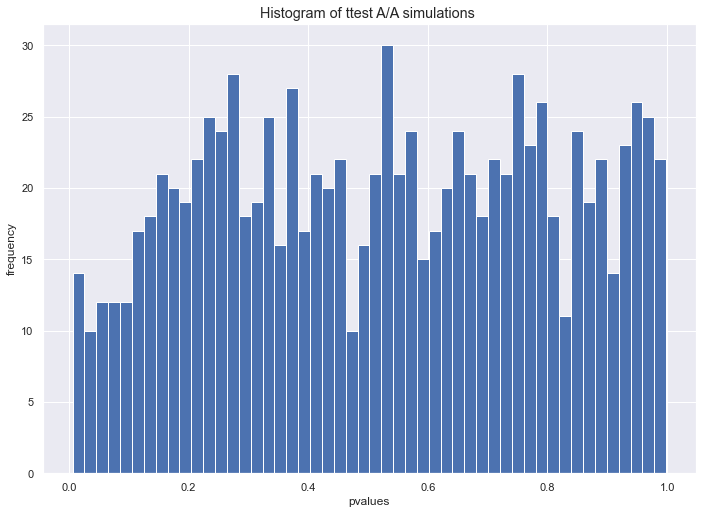

0.026

In [44]:
n = 100000
simulations = 1000
n_s = 1000
res = []
c1 = users.query('group_type == "control_1"')
c2 = users.query('group_type == "control_2"')


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = c1.total_revenue.sample(n_s, replace = False).values
    s2 = c2.total_revenue.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

По результатам проведенного А/А-тестирования стат. значимых различий не выявлено. Считаем, что система сплитования работает корректно.

# Проведение А/В-теста

Статистические гипотезы:
- средние значения total_revenue в контрольных группах значимо не отличаются от среднего значения в тестовой группе;
- средние значения total_revenue (при total_revenue > 0) в контрольных группах значимо не отличаются от среднего значения в тестовой группе;
- снижение доли платящих клиентов в тестовой группе по сравнению с контрольными группами статистически не значимо.

###### Проверим распределения на нормальность с помощью теста Шапиро

In [45]:
a = users.query('group_type == "test" and total_revenue > 0').total_revenue
b = users.query('group_type == "control_1" and total_revenue > 0').total_revenue
c = users.query('group_type == "control_2" and total_revenue > 0').total_revenue
d = users.query('group_type == "test"').total_revenue
e = users.query('group_type == "control_1"').total_revenue
f = users.query('group_type == "control_2"').total_revenue

In [46]:
print(stats.shapiro(a))
print(stats.shapiro(b))
print(stats.shapiro(c))
print(stats.shapiro(d))
print(stats.shapiro(e))
print(stats.shapiro(f))

ShapiroResult(statistic=0.5494610071182251, pvalue=2.530081054497636e-19)
ShapiroResult(statistic=0.6391915082931519, pvalue=6.679394912190761e-20)
ShapiroResult(statistic=0.6258848905563354, pvalue=5.0175247612037996e-20)
ShapiroResult(statistic=0.09915435314178467, pvalue=0.0)
ShapiroResult(statistic=0.14440131187438965, pvalue=0.0)
ShapiroResult(statistic=0.144597589969635, pvalue=0.0)


По результатам проведенного тестирования установлено, что распределение значимо отличается от нормального.

###### Оценим равенство дисперсий с помощью теста Левена.

In [47]:
test_leven, p = stats.levene(a, b, c)
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=3.505, p-value=0.031
Отклонить гипотезу о равенстве дисперсий


In [48]:
test_leven, p = stats.levene(d, e, f)
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=0.624, p-value=0.536
Принять гипотезу о равенстве дисперсий


Так как дисперсии во втором случае равны, можем провести многофакторный дисперсионный анализ.

In [49]:
stats.f_oneway(d, e, f)

F_onewayResult(statistic=0.6242779764703723, pvalue=0.5356642136087857)

Так как p-значение больше 0.05, то мы делаем вывод, что средние групп значимо не отличается друг от друга.

#### Таким образом, мы можем сказать, что эксперимент не принес положительных результатов.
#### Статистически значимых изменений в части увеличения total_revenue в тестовой группе не выявлено.

### Проверим статистически значимо ли изменение доли платящих клиентов

In [50]:
print(users.query('group_type == "test"').uid.count()) # считаем общее количество клиентов в тестовой группе
print(users.query('group_type == "test" and total_revenue > 0').uid.count()) # считаем количество платящих клиентов в тестовой группе
print(users.query('group_type == "control_1"').uid.count()) # считаем общее количество клиентов в первой контрольной группе
print(users.query('group_type == "control_1" and total_revenue > 0').uid.count()) # считаем количество платящих клиентов в первой контрольной группе
print(users.query('group_type == "control_2"').uid.count()) # считаем общее количество клиентов во второй контрольной группе
print(users.query('group_type == "control_2" and total_revenue > 0').uid.count()) # считаем количество платящих клиентов во второй контрольной группе

4307
146
4339
191
4263
187


In [66]:
t_paying = 146 # число платящих клиентов в тестовой группе
t_total  = 4307 # общее число клиентов в тестоой группе

c1_paying = 191 # число платящих клиентов в котрольной группе 1
c1_total  = 4339 # общее число клиентов в котрольной группе 1

c2_paying = 187 # число платящих клиентов в котрольной группе 2
c2_total  = 4263 # общее число клиентов в котрольной группе 2


z1, p_value1 = sm.stats.proportions_ztest([t_paying, c1_paying], [t_total, c1_total])
print(['{:.12f}'.format(a) for a in (z1, p_value1)])

z2, p_value2 = sm.stats.proportions_ztest([t_paying, c2_paying], [t_total, c2_total])
print(['{:.12f}'.format(b) for b in (z2, p_value2)])

z3, p_value3 = sm.stats.proportions_ztest([c1_paying, c2_paying], [c1_total, c2_total])
print(['{:.12f}'.format(с) for с in (z3, p_value3)])

['-2.431231409530', '0.015047600411']
['-2.387348676354', '0.016970387527']
['0.034735864903', '0.972290362117']


### По результатам проведенного исследования установлено, что снижение доли платящих клиентов в тестовой группе по сравнению с контрольными является статистически значимым.

## Таким образом, в совокупности факторов можно сделать следующий вывод:
Экперимент не был успешным. Доля платящих клиентов снизилась. Статистически значимых изменений в увеличении total_revenue не выявлено.

### Рассмотрим изменения по группам пользователей: в возрасте 25-45 лет и по странам.

In [52]:
g = users.query('group_type == "test" and age_category == ["25-35", "35-45"]').total_revenue
h = users.query('group_type == "control_1" and age_category == ["25-35", "35-45"]').total_revenue
i = users.query('group_type == "control_2" and age_category == ["25-35", "35-45"]').total_revenue
j = users.query('group_type == "test" and age_category == ["25-35", "35-45"] and total_revenue > 0').total_revenue
k = users.query('group_type == "control_1" and age_category == ["25-35", "35-45"] and total_revenue > 0').total_revenue
l = users.query('group_type == "control_2" and age_category == ["25-35", "35-45"] and total_revenue > 0').total_revenue

In [53]:
print(stats.shapiro(g))
print(stats.shapiro(h))
print(stats.shapiro(i))
print(stats.shapiro(j))
print(stats.shapiro(k))
print(stats.shapiro(l))

ShapiroResult(statistic=0.09905356168746948, pvalue=0.0)
ShapiroResult(statistic=0.16032308340072632, pvalue=0.0)
ShapiroResult(statistic=0.14108127355575562, pvalue=0.0)
ShapiroResult(statistic=0.5312001705169678, pvalue=8.003861546347364e-16)
ShapiroResult(statistic=0.754463255405426, pvalue=4.353747397323193e-12)
ShapiroResult(statistic=0.6131981611251831, pvalue=7.069449739045494e-16)


In [54]:
test_leven, p = stats.levene(g, h, i)
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=1.079, p-value=0.340
Принять гипотезу о равенстве дисперсий


In [55]:
test_leven, p = stats.levene(j, k, l)
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=2.768, p-value=0.064
Принять гипотезу о равенстве дисперсий


In [56]:
print(stats.f_oneway(g, h, i))
print(stats.f_oneway(j, k, l))

F_onewayResult(statistic=1.0788331954527908, pvalue=0.34004451579759776)
F_onewayResult(statistic=5.103255671266959, pvalue=0.006594226990849622)


Согласно полученным данным, среднее в одной из групп значимо отличается от средних других групп (j, k , l).

In [57]:
print(stats.f_oneway(j, k))
print(stats.f_oneway(j, l))
print(stats.f_oneway(k, l))

F_onewayResult(statistic=7.526102904344392, pvalue=0.006636538993347301)
F_onewayResult(statistic=4.923779937495258, pvalue=0.027580744486312765)
F_onewayResult(statistic=0.43161795410685516, pvalue=0.5118859166537121)


###### Полученные результаты свидетельствуют о том, что в тестовой группе средний доход с платящих клиентов занчимо отличается от среднего дохода платящих клиентов в контрольных группах.
###### Можем сделать вывод о том, что нововведение имеет смысл среди платящих клиентов в возрасте от 25 до 45 лет.

In [58]:
# Разделим группы пользователей по странам.
m = users.query('group_type == "test" and country == ["Argentina", "France", "Germany", "Mexico", "Spain", "United Arab Emirates", "United States of America"]').total_revenue
n = users.query('group_type == "control_1" and country == ["Argentina", "France", "Germany", "Mexico", "Spain", "United Arab Emirates", "United States of America"]').total_revenue
o = users.query('group_type == "control_2" and country == ["Argentina", "France", "Germany", "Mexico", "Spain", "United Arab Emirates", "United States of America"]').total_revenue
pp = users.query('group_type == "test" and country == ["Argentina", "France", "Germany", "Mexico", "Spain", "United Arab Emirates", "United States of America"] and total_revenue > 0').total_revenue
q = users.query('group_type == "control_1" and country == ["Argentina", "France", "Germany", "Mexico", "Spain", "United Arab Emirates", "United States of America"] and total_revenue > 0').total_revenue
r = users.query('group_type == "control_2" and country == ["Argentina", "France", "Germany", "Mexico", "Spain", "United Arab Emirates", "United States of America"] and total_revenue > 0').total_revenue

In [59]:
print(stats.shapiro(m))
print(stats.shapiro(n))
print(stats.shapiro(o))
print(stats.shapiro(pp))
print(stats.shapiro(q))
print(stats.shapiro(r))

ShapiroResult(statistic=0.09692245721817017, pvalue=0.0)
ShapiroResult(statistic=0.14268803596496582, pvalue=0.0)
ShapiroResult(statistic=0.12023264169692993, pvalue=0.0)
ShapiroResult(statistic=0.5420057773590088, pvalue=1.8378691925930254e-16)
ShapiroResult(statistic=0.6559048891067505, pvalue=5.6879003561955115e-15)
ShapiroResult(statistic=0.579380452632904, pvalue=1.2866675314254138e-16)


In [60]:
test_leven, p = stats.levene(m, n, o)
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=2.424, p-value=0.089
Принять гипотезу о равенстве дисперсий


In [61]:
test_leven, p = stats.levene(pp, q, r)
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))
alpha = 0.05
if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=3.538, p-value=0.030
Отклонить гипотезу о равенстве дисперсий


In [62]:
print(stats.f_oneway(m, n, o))

F_onewayResult(statistic=2.423704433444669, pvalue=0.08865129536460531)


Так как p-значение больше 0.05, то мы делаем вывод, что средние групп значимо не отличается друг от друга.
#### Таким образом, разделение пользователей по странам не принесло положительных результатов.

# Вывод.

По результатам проведенного тестирования мы установили следующее:
- ARPU и ARPPU тестовой группы значимо не отличаются от значений контрольных групп;
- доля платящих клиентов в тестовой группе статистически значимо снизилась;
- ARPPU тестовой группы значимо отличается от ARPPU контрольных групп в сегменте пользователей в возрасте от 25 до 45 лет;
- сегментация пользователей по странам также не показала значимых изменений.

Таким образом, можем сделать вывод о том, что в общем и целом эксперимент не был успешен. Применять нововведения на весь проект не целесообразно.
Возможно, имеет смысл провести дополнительные исследования в группе платящих пользователей в возрате от 25 до 45 лет.